# **LOADING THE DATASET**

In [1]:
import pandas as pd

# Read the uploaded CSV file
df = pd.read_csv("TRADES_CopyTr_90D_ROI.csv")

# Display the first 5 records
print(df.head())

              Port_IDs                                      Trade_History
0  3925368433214965504  [{'time': 1718899656000, 'symbol': 'SOLUSDT', ...
1  4002413037164645377  [{'time': 1718980078000, 'symbol': 'NEARUSDT',...
2  3923766029921022977  [{'time': 1718677164000, 'symbol': 'ETHUSDT', ...
3  3994879592543698688  [{'time': 1718678214000, 'symbol': 'ETHUSDT', ...
4  3926423286576838657  [{'time': 1718979615000, 'symbol': 'ETHUSDT', ...


# **DATA EXPLORATION AND CLEANING**

In [2]:
import pandas as pd
import ast

# Assuming df is the original DataFrame with 'Trade_History' as a column

# Forward fill the missing Trade_History based on the previous row
df['Trade_History'].fillna(method='ffill', inplace=True)

# Apply ast.literal_eval to convert string representations of lists/dictionaries to actual Python objects
df['Trade_History'] = df['Trade_History'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Shuffle the dataset (randomize the rows)
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Now df_shuffled contains the shuffled data
print(df_shuffled.head())  # Show the top few rows to verify

# If you want to save the shuffled DataFrame as a CSV
df_shuffled.to_csv('shuffled_data.csv', index=False)


<ipython-input-2-4b07036878a7>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Trade_History'].fillna(method='ffill', inplace=True)
<ipython-input-2-4b07036878a7>:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Trade_History'].fillna(method='ffill', inplace=True)


              Port_IDs                                      Trade_History
0  4004410127575640832  [{'time': 1718892183000, 'symbol': 'ARKMUSDT',...
1  4023697881318718465  [{'time': 1718641182000, 'symbol': 'DOGEUSDT',...
2  3943533600390906881  [{'time': 1718899769000, 'symbol': 'RONINUSDT'...
3  3993014919980212480  [{'time': 1718972350000, 'symbol': 'ETHUSDT', ...
4  4000877324693233921  [{'time': 1718905659000, 'symbol': 'WIFUSDT', ...


# **FEATURE ENGINEERING**

{'Logistic Regression': {'accuracy': 0.0,
                         'feature_importances': array([0.18249543, 0.35613371, 0.22501611, 0.17095815, 0.61108571,
       0.20525334, 0.16795566, 0.15573246, 0.01974751, 0.01761401])},
 'Random Forest': {'accuracy': 0.0,
                   'feature_importances': array([0.11453991, 0.10526052, 0.10073587, 0.10855872, 0.10062065,
       0.10247396, 0.10083285, 0.11248226, 0.07953575, 0.07495951])},
 'Support Vector Classifier': {'accuracy': 0.0,
                               'feature_importances': array([0.45141818, 0.45299012, 0.38998249, 0.3597895 , 0.89693158,
       0.06465062, 0.10882794, 0.2178067 , 0.5206314 , 0.2462872 ])}}


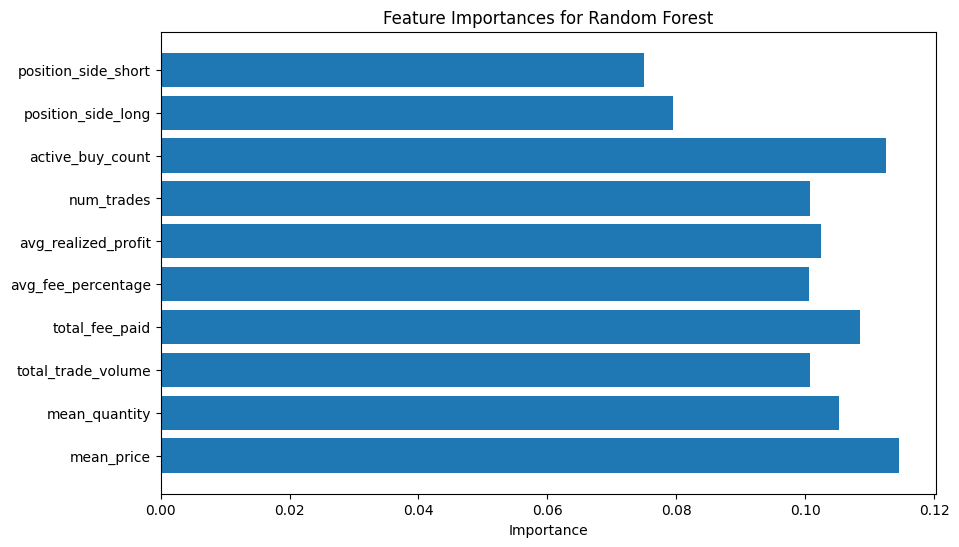

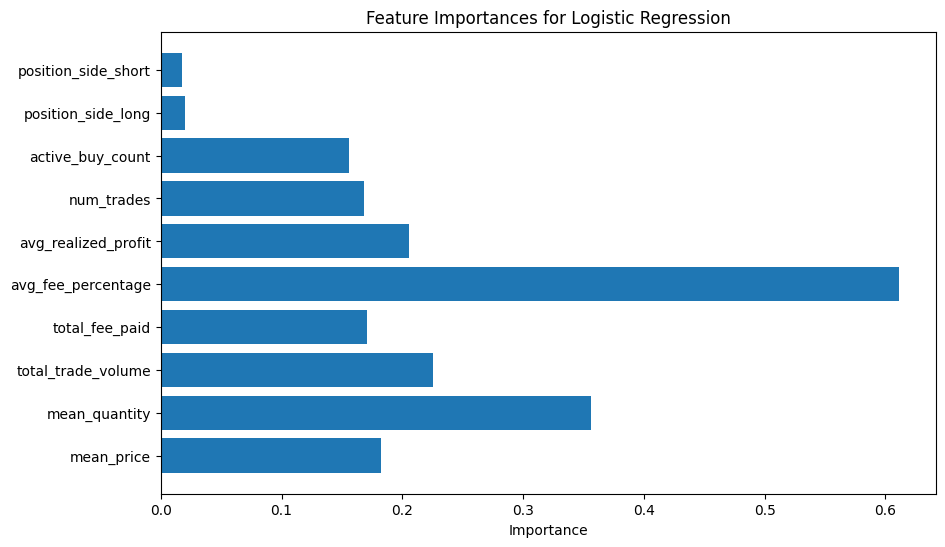

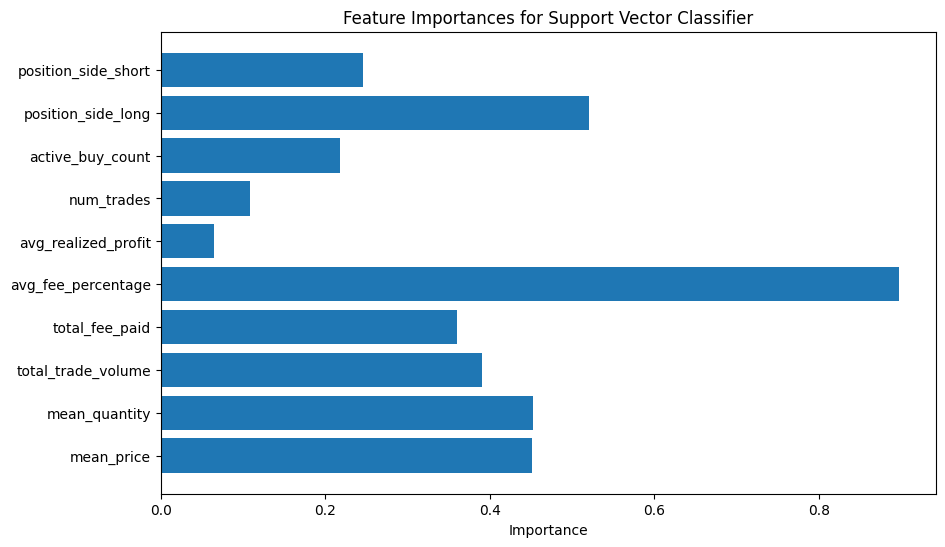

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from pprint import pprint
import matplotlib.pyplot as plt

# Feature extraction from 'Trade_History': Extract additional features
def extract_trade_features(trade_history):
    if isinstance(trade_history, list) and trade_history:
        prices = [trade['price'] for trade in trade_history if isinstance(trade, dict) and 'price' in trade]
        quantities = [trade['quantity'] for trade in trade_history if isinstance(trade, dict) and 'quantity' in trade]
        fees = [trade['fee'] for trade in trade_history if isinstance(trade, dict) and 'fee' in trade]
        realized_profits = [trade['realizedProfit'] for trade in trade_history if isinstance(trade, dict) and 'realizedProfit' in trade]
        active_buy = [trade['activeBuy'] for trade in trade_history if isinstance(trade, dict) and 'activeBuy' in trade]
        position_side = [trade['positionSide'] for trade in trade_history if isinstance(trade, dict) and 'positionSide' in trade]

        # New features
        total_trade_volume = np.sum(quantities) if quantities else 0
        total_fee_paid = np.sum(fees) if fees else 0
        avg_fee_percentage = total_fee_paid / total_trade_volume if total_trade_volume else 0
        avg_realized_profit = np.mean(realized_profits) if realized_profits else 0
        num_trades = len(trade_history)
        active_buy_count = sum(active_buy)
        position_side_long = sum(1 for pos in position_side if pos == 'LONG')
        position_side_short = sum(1 for pos in position_side if pos == 'SHORT')

        return {
            'mean_price': np.mean(prices) if prices else 0,
            'mean_quantity': np.mean(quantities) if quantities else 0,
            'total_trade_volume': total_trade_volume,
            'total_fee_paid': total_fee_paid,
            'avg_fee_percentage': avg_fee_percentage,
            'avg_realized_profit': avg_realized_profit,
            'num_trades': num_trades,
            'active_buy_count': active_buy_count,
            'position_side_long': position_side_long,
            'position_side_short': position_side_short
        }
    return {
        'mean_price': 0,
        'mean_quantity': 0,
        'total_trade_volume': 0,
        'total_fee_paid': 0,
        'avg_fee_percentage': 0,
        'avg_realized_profit': 0,
        'num_trades': 0,
        'active_buy_count': 0,
        'position_side_long': 0,
        'position_side_short': 0
    }

# Apply the feature extraction function to the 'Trade_History' column
extracted_features = df['Trade_History'].apply(extract_trade_features)

# Convert the extracted features into separate columns
df_features = pd.DataFrame(extracted_features.tolist())

# Merge the new features with the original dataframe
df = pd.concat([df, df_features], axis=1)

# Encode 'Port_IDs' as the target variable
le = LabelEncoder()
df['Port_IDs_encoded'] = le.fit_transform(df['Port_IDs'].astype(str))

# Create feature matrix (X) and target vector (y)
X = df.drop(columns=['Port_IDs', 'Port_IDs_encoded', 'Trade_History'])
y = df['Port_IDs_encoded']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize models (without KNN)
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=200, random_state=42),
    'Support Vector Classifier': SVC(kernel='linear', random_state=42)  # Use linear kernel for feature importance
}

# Initialize an empty results dictionary and clear it to ensure it's fresh
results = {}
results.clear()

# Train models, evaluate accuracy, and display feature importances
for model_name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions and evaluate accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Store accuracy and feature importances
    results[model_name] = {'accuracy': accuracy}

    if hasattr(model, 'feature_importances_'):  # For Random Forest
        importances = model.feature_importances_
        results[model_name]['feature_importances'] = importances
    elif hasattr(model, 'coef_'):  # For Logistic Regression and SVC
        importances = np.abs(model.coef_[0])
        results[model_name]['feature_importances'] = importances
    else:
        results[model_name]['feature_importances'] = None

# Display results in a readable format
pprint(results)

# Optionally, you can visualize the feature importances
for model_name, model_results in results.items():
    if 'feature_importances' in model_results and model_results['feature_importances'] is not None:
        plt.figure(figsize=(10, 6))
        plt.title(f'Feature Importances for {model_name}')
        plt.barh(range(len(model_results['feature_importances'])), model_results['feature_importances'], align='center')
        plt.yticks(range(len(model_results['feature_importances'])), X.columns)
        plt.xlabel('Importance')
        plt.show()


# **RANKING ALGORITHM**

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Example DataFrame (replace this with your actual data)
# Assuming `df` has columns like 'Port_IDs', 'Trade_History', and the extracted metrics.
# df = pd.read_csv('your_input_file.csv')

# Assuming feature importances from the Random Forest model
random_forest_feature_importances = np.array([0.11453991, 0.10526052, 0.10073587, 0.10855872,
                                              0.10062065, 0.10247396, 0.10083285, 0.11248226,
                                              0.07953575, 0.07495951])

# Function to calculate ranking scores based on metrics and Random Forest feature importances
def rank_accounts_with_rf_weights(df, feature_importances):
    # Normalize the metrics using StandardScaler
    scaler = StandardScaler()

    # Assuming these are the columns representing the calculated metrics
    metrics = ['total_trade_volume', 'avg_realized_profit', 'active_buy_count', 'avg_fee_percentage',
               'position_side_long', 'position_side_short']

    # Standardize the metrics
    df[metrics] = scaler.fit_transform(df[metrics])

    # Normalize the feature importances to sum to 1 (as weights)
    total_importance = np.sum(feature_importances)
    normalized_weights = feature_importances / total_importance

    # Calculate composite score for each account
    df['composite_score'] = (df['total_trade_volume'] * normalized_weights[0] +
                             df['avg_realized_profit'] * normalized_weights[1] +
                             df['active_buy_count'] * normalized_weights[2] +
                             df['avg_fee_percentage'] * normalized_weights[3] +
                             df['position_side_long'] * normalized_weights[4] +
                             df['position_side_short'] * normalized_weights[5])

    # Rank accounts based on composite score (higher score = higher rank)
    df['rank'] = df['composite_score'].rank(ascending=False)

    # Sort by rank for easier viewing
    df_sorted = df.sort_values('rank')

    return df_sorted[['Port_IDs', 'composite_score', 'rank']]

# Assuming df is the DataFrame containing the account information and metrics
ranked_accounts_rf = rank_accounts_with_rf_weights(df, random_forest_feature_importances)

# Save the result to a CSV file
ranked_accounts_rf.to_csv('ranked_accounts.csv', index=False)

# Show top 20 accounts
top_20_accounts = ranked_accounts_rf.head(20)
print("Top 20 Accounts based on Ranking:")
print(top_20_accounts)



Top 20 Accounts based on Ranking:
                Port_IDs  composite_score  rank
82   4020204877254599680         1.713795   1.0
76   4000877324693233921         1.249632   2.0
60   3936410995029308417         1.130717   3.0
139  4017263283405469185         1.031702   4.0
85   4022641794255717633         0.906926   5.0
5    3987739404272887297         0.770053   6.0
72   4021243448368889856         0.705151   7.0
64   3960874214179953664         0.696420   8.0
99   3784403294629753856         0.638789   9.0
56   3939925275039085824         0.586203  10.0
100  3977078013600312321         0.564308  11.0
23   4021669203289716224         0.532972  12.0
144  3988187872032603905         0.519531  13.0
127  3999240873283311617         0.494293  14.0
22   3956076827719377409         0.401730  15.0
116  3976088733682659585         0.399382  16.0
11   3878631538480067329         0.388866  17.0
124  3949214983441029120         0.380188  18.0
102  3951723256343550465         0.351906  19.0
43   3